In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 28.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/hojunlee-hj/CapstoneDesign/main/Data/pos_neg_genie_review_dataset.txt", filename="pos_neg_genie_review_dataset.txt")

('pos_neg_genie_review_dataset.txt',
 <http.client.HTTPMessage at 0x7f102d06bc10>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

temp_data = pd.read_csv('pos_neg_genie_review_dataset.txt', header = 0, delimiter = '\t', quoting=3)

In [5]:
temp_data

,id,document,label
0,1,요즘 뮤직 기능 말고도 오디오도 잘 듣고 있는데요,1
1,2,오디오는 배나 배로 빨리 돌릴 수 있으면 좋겠어요,0
2,3,그리고 오디오의 내용을 짧게라도 텍스트로 정리된 것을 함께 볼 수 있다면 오디오의 ...,0
3,4,또 오디오로의 접근성이 좋아 보이진 않았어요,0
4,5,음악만 들었던 사람들에게는 첫 화면에서 다른 오디오 컨텐츠가 있다는 걸 알기 힘들었습니다,0
...,...,...,...
4997,4998,자 노래듣다가 갑자기 로그아웃되서 분듣기로 바뀌고 다시 재로그인하면 분그대로 결국 ...,0
4998,4999,곡들을 여러개 선택하려면 전부 하나하나 눌러야하는것뿐만아니라 마이앨범을 밀어주는것처...,0
4999,5000,다른 아이디로 정기결제를 하고 다른 아이디로는 그 결제 선물로 주는 회 이용권을 받...,0
5000,5001,제대로 수령받은거 맞고 이미 수령한 이용권이라 나오는데 왜 이용중인 이용권이 없다고...,0


In [6]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('Genie dataset: ', len(temp_data))
train_data = train_data.append(temp_data[:3500], ignore_index=True)
test_data = test_data.append(temp_data[3500:], ignore_index=True)
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('Genie dataset: ', len(test_data))

훈련용 리뷰 개수 : 150000
Genie dataset:  5002
훈련용 리뷰 개수 : 153500
Genie dataset:  51502


In [7]:
train_data[:5] # 상위 5개 출력


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력


테스트용 리뷰 개수 : 51502


In [9]:
test_data[:5]


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(149643, 2)

In [11]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [12]:
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 149644


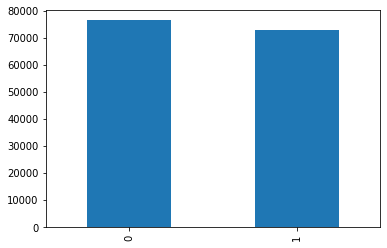

In [13]:
train_data['label'].value_counts().plot(kind = 'bar')


In [14]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  76588
1      1  73056


In [15]:
print(train_data.isnull().values.any())


True


In [16]:
print(train_data.isnull().sum())


id          0
document    1
label       0
dtype: int64


In [17]:
train_data.loc[train_data.document.isnull()]


,id,document,label
25857,2172111,NaN,1


In [18]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [19]:
print(len(train_data))


149643


In [20]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [21]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [22]:
train_data.loc[train_data.document.isnull()][:5]


,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [23]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

148854


In [24]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 50344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [27]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 148854/148854 [08:17<00:00, 299.00it/s]


In [28]:
print(X_train[:3])


[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [29]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 50344/50344 [03:08<00:00, 266.51it/s]


In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
print(tokenizer.word_index)


{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '만': 12, '적': 13, '재밌다': 14, '같다': 15, '진짜': 16, '로': 17, '않다': 18, '아니다': 19, '점': 20, '에서': 21, '나오다': 22, '만들다': 23, '것': 24, '연기': 25, '평점': 26, '내': 27, '안': 28, '그': 29, '최고': 30, '나': 31, '인': 32, '못': 33, '생각': 34, '스토리': 35, '왜': 36, '드라마': 37, '게': 38, '사람': 39, '감동': 40, '이렇다': 41, '때': 42, '보고': 43, '고': 44, '말': 45, '더': 46, '아깝다': 47, 'ㅋㅋ': 48, '배우': 49, '요': 50, '거': 51, '그냥': 52, '아': 53, '감독': 54, '재미있다': 55, '중': 56, '시간': 57, '재미': 58, '까지': 59, '뭐': 60, '자다': 61, '내용': 62, '하고': 63, '주다': 64, '수': 65, '지루하다': 66, '재미없다': 67, '들다': 68, '네': 69, '쓰레기': 70, '모르다': 71, '가다': 72, '그렇다': 73, '싶다': 74, '지': 75, '다시': 76, '알다': 77, '작품': 78, '사랑': 79, '하나': 80, '마지막': 81, '안되다': 82, '볼': 83, '저': 84, '정도': 85, '많다': 86, '이건': 87, '오다': 88, '완전': 89, 'ㅠㅠ': 90, '처음': 91, 'ㅋ': 92, 'ㅋㅋㅋ': 93, '장면': 94, '액션': 95, '이렇게': 96, '주인공': 97, '걸': 98, '차다': 99, '하': 100, '개': 101, '나다': 1

In [32]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44248
등장 빈도가 2번 이하인 희귀 단어의 수: 24546
단어 집합에서 희귀 단어의 비율: 55.47369372627011
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8232253595281689


In [33]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19703


In [34]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[:3])


[[53, 469, 16, 257, 685], [969, 470, 43, 625, 1, 216, 1513, 25, 970, 698, 18], [392, 2534, 2391, 5657, 2, 222, 9]]


In [36]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [37]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [38]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

148623
148623


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 122
리뷰의 평균 길이 : 10.928046130141365


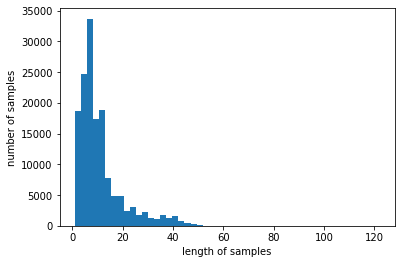

In [39]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [41]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.1933617273235


In [42]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [51]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import save_model


embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128, validation_split=0.2)
save_model(model,'/content/sample_data/')

Epoch 1/15
926/929 [============================>.] - ETA: 0s - loss: 0.3994 - acc: 0.8217
Epoch 1: val_acc improved from -inf to 0.82570, saving model to best_model.h5
929/929 [==============================] - 11s 9ms/step - loss: 0.3993 - acc: 0.8218 - val_loss: 0.4204 - val_acc: 0.8257
Epoch 2/15
926/929 [============================>.] - ETA: 0s - loss: 0.3239 - acc: 0.8601
Epoch 2: val_acc improved from 0.82570 to 0.83637, saving model to best_model.h5
929/929 [==============================] - 8s 9ms/step - loss: 0.3239 - acc: 0.8601 - val_loss: 0.3703 - val_acc: 0.8364
Epoch 3/15
928/929 [============================>.] - ETA: 0s - loss: 0.2979 - acc: 0.8739
Epoch 3: val_acc improved from 0.83637 to 0.83950, saving model to best_model.h5
929/929 [==============================] - 7s 8ms/step - loss: 0.2980 - acc: 0.8739 - val_loss: 0.3698 - val_acc: 0.8395
Epoch 4/15
926/929 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.8844
Epoch 4: val_acc did not improve

In [50]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1574/1574 [==============================] - 6s 4ms/step - loss: 0.3581 - acc: 0.8445

 테스트 정확도: 0.8445


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')


In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')


In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')


In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')


In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')
